In [1]:
import json
from pathlib import Path

d = {}

for f in Path("./d").glob("*.json"):
    d[f.stem] = json.load(open(f))

from pymongo import MongoClient

client = MongoClient()
client.drop_database("factorio")
db = client.factorio

del d["active_mods"]
for k, vs in d.items():
    for v in vs.values():
        db[k.replace("-", "_")].insert_one(dict(**v, **{"_id":v['name']}))


ModuleNotFoundError: No module named 'pymongo'

In [29]:
class HyperDiGraph:
    def __init__(self):
        self._edges = []
        self._nodes = set()

    def add_edge(self, A, B, data=None):
        self._edges.append((A, B, data))
        self._nodes.update(A)
        self._nodes.update(B)
    
    def in_edges(self, v):
        assert v in self._nodes
        return [(e[0], e[1]) for e in self._edges if v in e[1]]

    def in_edges_data(self, v):
        assert v in self._nodes
        return [e for e in self._edges if v in e[1]]

    def out_edges(self, v):
        assert v in self._nodes
        return [(e[0], e[1]) for e in self._edges if v in e[0]]

    def out_edges_data(self, v):
        assert v in self._nodes
        return [e for e in self._edges if v in e[0]]

    def edges(self):
        return [(e[0], e[1]) for e in self._edges]

    def edges_data(self):
        return [e for e in self._edges]

    def nodes(self):
        return [v for v in self._nodes]
    
    def edge_by_name(self, name):
        return next(d for (_, _, d) in self._edges if d["name"] == name)

In [30]:
g = HyperDiGraph()

for r in db.recipe.find({"hidden": False}):
    query = {f"crafting_categories.{r['category']}": {"$exists": True}, "name": {"$nin": ["kr-crash-site-assembling-machine-1-repaired", "kr-crash-site-assembling-machine-2-repaired"]}}
    for m in [m for m in db.assembling_machine.find(query)] + [m for m in db.furnace.find(query)]:
        
        if m["name"] in {"kr-advanced-assembling-machine", 'kr-advanced-chemical-plant', 'kr-advanced-furnace', "steel-furnace"}:
            continue

        A = {i["name"] for i in r["ingredients"]}
        B = {p["name"] for p in r["products"]}
        g.add_edge(A, B, {"recipe": r, "machine": m, "name": f"{r['name']}#{m['name']}"})

# display(next(iter(g.edges_data())))

In [31]:
import mip

def compute_cost(data):
    return 1 # data["machine"]["energy_usage"]

def ingredient_coef(data, v):
    coef = data["machine"]["crafting_speed"] * sum(i["amount"] for i in data["recipe"]["ingredients"] if i["name"] == v) / data["recipe"]["energy"]
    assert coef > 0
    return coef

def product_coef(data, v):
    try:
        coef = data["machine"]["crafting_speed"] * sum(p["amount"]*p["probability"] for p in data["recipe"]["products"] if p["name"] == v) / data["recipe"]["energy"]
    except:
        coef = data["machine"]["crafting_speed"] * sum((p["amount_min"] + p["amount_max"])/2*p["probability"] for p in data["recipe"]["products"] if p["name"] == v) / data["recipe"]["energy"]
    assert coef > 0
    return coef

def build_model(graph, sources):
    model = mip.Model()

    flow_int = {data["name"]: model.add_var(f"flow_{data['name']}", lb=0, obj=compute_cost(data), var_type=mip.INTEGER) for a, b, data in graph.edges_data()}
    flow = {data["name"]: model.add_var(f"flow_{data['name']}", lb=0, obj=compute_cost(data)) for a, b, data in graph.edges_data()}
    
    for _, _, d in graph.edges_data():
        model.add_constr(flow[d["name"]] <= flow_int[d["name"]])
    
    diffs = {}    
    produced = {}
    used = {}
    
    
    considered = {}
    

    for v in graph.nodes():
        
        diff = mip.quicksum(flow[data["name"]] * ingredient_coef(data, v) for (_, _, data) in graph.out_edges_data(v)) - mip.quicksum(flow[data["name"]] * product_coef(data, v) for (_, _, data) in graph.in_edges_data(v))
        diffs[v] = diff
        
        considered[v] = mip.quicksum(flow[data["name"]] * ingredient_coef(data, v) for (_, _, data) in graph.out_edges_data(v)) + mip.quicksum(flow[data["name"]] * product_coef(data, v) for (_, _, data) in graph.in_edges_data(v))
        
        
        for (_, _, data) in graph.in_edges_data(v):
            used[v, data["name"]] = flow[data["name"]] * product_coef(data, v)
        
        for (_, _, data) in graph.out_edges_data(v):
            produced[v, data["name"]] = flow[data["name"]] * ingredient_coef(data, v)
        
        # model.objective = model.objective - diff
        
        
        if v in sources:
            model.add_constr(diff <= sources[v])
        else:
            model.add_constr(diff <= 0)

    model.optimize()
    print(model.status)

    return(
        {k: v.x for k, v in diffs.items() if v.x != 0},
        {k for k, v in considered.items() if v.x != 0},
        {k: v.x for k, v in used.items() if v.x != 0},
        {k: v.x for k, v in produced.items() if v.x != 0},
        {k: v.x for k, v in flow.items() if v.x is not None and v.x > 0},
        {k: v.x for k, v in flow_int.items() if v.x is not None and int(v.x) > 0},
    )

In [32]:
# Semantic decomposition of items using recipes.

grouped = []
for r in db.recipe.find({"hidden": False}):
    if "main_product" in r:
        grouped.append(((r["group"]["name"], (r["subgroup"]["name"], r["main_product"]["name"]))))

from collections import defaultdict
gg = defaultdict(lambda: defaultdict(set))
for r in db.recipe.find({"hidden": False}):
    if "main_product" in r:
        gg[r["group"]["name"]][r["subgroup"]["name"]].add(r["main_product"]["name"])

grouped = sorted(grouped)

# [(k1, k2, len(v2)) for k1, v1 in gg.items() for k2, v2 in v1.items()]

In [33]:
# flows, config = build_model(g, {"iron-ore": float("+inf"), "crude-oil": float("+inf"),"copper-ore": float("+inf"), "assembling-machine-3": -1})

source = {
    "iron-ore": float("+inf"),
    "crude-oil": float("+inf"),
    "copper-ore": float("+inf"),
    "stone": float("+inf"),
    "coal": float("+inf"),
    "watter": float("+inf"),
    "wood": float("+inf"),
    "brick": float("+inf"),
    "steel-plate": float("+inf"),
    "plastic": float("+inf"),
    "advanced-tech-card": -1,
}

bli = gg['production']['module'] | gg['production']['production-machine'] | gg['production']['extraction-machine'] | gg['production']['smelting-machine'] | gg['production']['tool']

bli = bli - {"kr-singularity-beacon", "kr-electric-mining-drill-mk3", "stone-furnace", "steel-furnace", "kr-advanced-assembling-machine", "kr-advanced-furnace", "kr-matter-plant#assembling-machine-3", "kr-matter-assembler#assembling-machine-3", "kr-stabilizer-charging-station", }
bli = bli - {'effectivity-module', 'effectivity-module-2', 'effectivity-module-3', 'speed-module', 'speed-module-2', 'speed-module-3', 'productivity-module',  'productivity-module-2',  'productivity-module-3'}
bla = gg['intermediate-products']['raw-material'] | gg['intermediate-products']['fluid-recipes'] | gg['intermediate-products']['raw-resource'] | gg['intermediate-products']['fill-barrel'] | {"iron-ore", "stone"}


source = dict(**{k: -1/1000 for k in bli}, **{k: float("+inf") for k in bla})
# source = {
#     "stone": float("+inf"),
#     "water": float("+inf"),
#     "glass": -15,
#     "quartz": -15,
#     "silicon": -15,
#     "chlorine": -15,
#     "stone-brick": -15,
# }

# source = {
#     "iron-ore": float("+inf"),
#     "crude-oil": float("+inf"),
#     "copper-ore": float("+inf"),
#     "stone": float("+inf"),
#     "coal": float("+inf"),
#     "water": float("+inf"),
#     "wood": float("+inf"),
#     "brick": float("+inf"),
#     "oil": float("+inf"),
#     "steel-plate": float("+inf"),
#     "plastic": float("+inf"),
#     "raw-rare-metals": float("+inf"),
#     "chlorine"
# flows, config = build_model(g, {"iron-ore": float("+inf"), "crude-oil": float("+inf"),"copper-ore": float("+inf"), "assembling-machine-3": -1})

source = {
    "iron-ore": float("+inf"),
    "crude-oil": float("+inf"),
    "copper-ore": float("+inf"),
    "stone": float("+inf"),
    "coal": float("+inf"),
    "watter": float("+inf"),
    "wood": float("+inf"),
    "brick": float("+inf"),
    "steel-plate": float("+inf"),
    "plastic": float("+inf"),
    "advanced-tech-card": -1,
}

bli = gg['production']['module'] | gg['production']['production-machine'] | gg['production']['extraction-machine'] | gg['production']['smelting-machine'] | gg['production']['tool']

bli = bli - {"kr-singularity-beacon", "kr-electric-mining-drill-mk3", "stone-furnace", "steel-furnace", "kr-advanced-assembling-machine", "kr-advanced-furnace", "kr-matter-plant", "kr-matter-assembler", "kr-stabilizer-charging-station", }
bli = bli - {'effectivity-module', 'effectivity-module-2', 'effectivity-module-3', 'speed-module', 'speed-module-2', 'speed-module-3', 'productivity-module',  'productivity-module-2',  'productivity-module-3'}

bla = gg['intermediate-products']['raw-material'] | gg['intermediate-products']['fluid-recipes'] | gg['intermediate-products']['raw-resource'] | gg['intermediate-products']['fill-barrel']
bla = bla | {"iron-ore", "stone"}

bli = {'speed-module-3', 'effectivity-module-3', 'productivity-module-3', 'beacon'}

source = dict(**{k: -1/30 for k in bli}, **{k: float("+inf") for k in bla})
# source = {
#     "stone": float("+inf"),
#     "water": float("+inf"),
#     "glass": -15,
#     "quartz": -15,
#     "silicon": -15,
#     "chlorine": -15,
#     "stone-brick": -15,
# }

# source = {
#     "iron-ore": float("+inf"),
#     "crude-oil": float("+inf"),
#     "copper-ore": float("+inf"),
#     "stone": float("+inf"),
#     "coal": float("+inf"),
#     "water": float("+inf"),
#     "wood": float("+inf"),
#     "brick": float("+inf"),
#     "oil": float("+inf"),
#     "steel-plate": float("+inf"),
#     "plastic": float("+inf"),
#     "raw-rare-metals": float("+inf"),
#     "chlorine": -30
# }
# source = {k: -100 for k in gg['intermediate-products']['science-pack']}

diffs, considered, used, produced, config, config_int = build_model(g, source)

# display(diffs)
print(f"total size: {sum(config_int.values())}")

config_int

dddd = defaultdict(int)
for k, v in [(k.split("#")[1], v) for k, v in config_int.items()]:
    dddd[k] += v
dddd = dict(dddd)

# display(considered)
# display(used)
# display(config)
# display(config_int)

display(diffs)
display(config_int)
display(dddd)


OptimizationStatus.OPTIMAL
total size: 111.0


{'speed-module-3': -0.03333333333333333,
 'electronic-circuit': 3.552713678800501e-15,
 'productivity-module-3': -0.03333333333333333,
 'glass': 15.08333333333334,
 'beacon': -0.03333333333333333,
 'electronic-components': 3.552713678800501e-15,
 'effectivity-module-3': -0.03333333333333333,
 'steel-plate': 0.33333333333333337,
 'sulfuric-acid': 2.5,
 'wood': 13.000000000000005,
 'rare-metals': 0.75,
 'silicon': 15.08333333333334,
 'plastic-bar': 15.08333333333334,
 'copper-plate': 31.333333333333346,
 'iron-plate': 13.000000000000005}

{'beacon#assembling-machine-3': 1.0,
 'copper-cable#assembling-machine-3': 13.0,
 'speed-module#assembling-machine-3': 10.0,
 'speed-module-2#assembling-machine-3': 2.0,
 'speed-module-3#assembling-machine-3': 1.0,
 'effectivity-module#assembling-machine-3': 10.0,
 'effectivity-module-2#assembling-machine-3': 2.0,
 'effectivity-module-3#assembling-machine-3': 1.0,
 'productivity-module#assembling-machine-3': 10.0,
 'productivity-module-2#assembling-machine-3': 2.0,
 'productivity-module-3#assembling-machine-3': 1.0,
 'electronic-components#assembling-machine-3': 25.0,
 'electronic-circuit#assembling-machine-3': 21.0,
 'advanced-circuit#assembling-machine-3': 9.0,
 'processing-unit#assembling-machine-3': 3.0}

{'assembling-machine-3': 111.0}

In [34]:
display(
    [x["belt_speed"] * 8 for x in db.transport_belt.find()]
)

[15.0, 30.0, 45.0, 60.0, 90.0]

In [35]:
def bin_packing_frac_balanced(A, B, k):
    # c capacity of all the bins
    
    model = mip.Model()
    
    x = {(a, b): model.add_var(f"x_{a}_{b}", obj=1, var_type=mip.BINARY) for a, b in product(A, B)}
    y = {b: model.add_var(f"y_{b}", obj=1000, var_type=mip.BINARY) for b in B}
    
    lambd = {(a, b): model.add_var(f"lambda_{a}_{b}", obj=0, lb=0, ub=1, var_type=mip.CONTINUOUS) for a, b in product(A, B)}
    alpha = {b: model.add_var(f"alpha_{b}", obj=0, lb=0, ub=1, var_type=mip.CONTINUOUS) for b in B}
    
    for b in B:
        model.add_constr(mip.quicksum(A[a] * lambd[a, b] for a in A) <= B[b] * y[b])
    
    for a in A:
        model.add_constr(mip.quicksum(lambd[a, b] for b in B) == 1)
    
    for a, b in product(A, B):

        # non-linear constraint `model.add_constr(lambd[a, b] == alpha[b] * x[a, b])` is remplaced by:
        model.add_constr(lambd[a, b] <= x[a, b])
        model.add_constr(lambd[a, b] <= alpha[b])
        model.add_constr(lambd[a, b] + 1 >= alpha[b] + x[a, b])
    
    for b in B:
        model.add_constr(mip.quicksum(x[a, b] for a in A) <= k)

    model.optimize()
    
    print(model.status)
    
    return {k for k, v in x.items() if v.x > 0}, {k for k, v in y.items() if v.x > 0}



In [36]:
def build_model_bipartite(graph, flows, considered, sources, used, produced, config, config_int):
    model = mip.Model()

    # flow = {data["name"]: model.add_var(f"flow_{data['name']}", lb=0, obj=compute_cost(data), var_type=mip.INTEGER) for a, b, data in graph.edges_data()}
    
    for v in graph.nodes():
        if v not in considered:
            continue
        
        print(f"{v}")

        
        print("  from:")
        for (_, _, data) in graph.in_edges_data(v):
            if data["name"] not in config_int:
                continue
            
            print(f"    {data['name']}:")
            print(f"      nb facilities: {int(config_int[data['name']])}")
            print(f"      goal: {used[v, data['name']]}")
            print(f"      part: {used[v, data['name']]}")
            print(f"      max: {config_int[data['name']] * product_coef(data, v)}")
        
        print("  middle")
        
        print("  to:")
        for (_, _, data) in graph.out_edges_data(v):
            if data["name"] not in config_int:
                continue
            
            print(f"    {data['name']}:")
            print(f"      nb facilities: {int(config_int[data['name']])}")
            print(f"      actual: {produced[v, data['name']]}")
            print(f"      max:{config_int[data['name']] * ingredient_coef(data, v)}")
            # print(flows[data["name"]] * ingredient_coef(data, v))
        
        print("-"*60)

        # model.objective = model.objective - diff
        
        
        # if v in sources:
        #     model.add_constr(diff <= sources[v])
        # else:
        #    model.add_constr(diff <= 0)

    model.optimize()
    print(model.status)

    return #  {k: v.x for k, v in used.items() if v.x != 0}, {k: v.x for k, v in flow.items() if v.x is not None and int(v.x) > 0}


# build_model_bipartite(g, diffs, considered, source, used, produced, config, config_int)

In [37]:
from itertools import product

def balanced_fractional_bin_packing(A, B, C):
    model = mip.Model()
    
    y = {b: model.add_var(f"y_{b}", var_type=mip.BINARY) for b in B}
    x = {(a, b): model.add_var(f"y_{a}#{b}", var_type=mip.BINARY) for a, b in product(A, B)}


## Study of the requester chest

In [38]:
import factorio

widget = factorio.loads("0eNqVU21vgjAQ/i/3GRZAUEf2TxZDCpx4CbSsLWzG8N93BcfU4dy+iAfPyz3X6wnyusNWk7SQnoAKJQ2krycwVElRu3f22CKkQBYb8ECKxlXCGGzymmTlN6I4kEQ/hMEDkiV+QBoOOw9QWrKEk95YHDPZNTlqBvyu5EGrDJOVdB2woB+unhIPjud/7KSxoLExlJUjdZIsd/DDKZqdalWRsVT4xQGN9TW+dfxkzIJbMLvFZ7cRnO2pZsYU6SvrbEBaSb+thUWWLFTnZhoFgWvqjI2usRUK7b8fEOt7hNVMaF3aGRUyareQ9htP0qC+ky68SVcST3NCRAui8b0RCib16Lda9VQ+GmQ0WvGCycnLOEzofjSWlztCXCWcblhoJflnvug233pswWpVZzkeRE9KO1pBuujIZvytnLX2pPnIH9yE6/Vz4sYKd0RJ4KqmFVpYZwIvMPx9APE4AL5Fo1t6cU096HkDp8PahvHmOdrE4Xq7ioJh+ATgSEIr")

baset1 = factorio.loads("0eNql2e1qgzAYhuFzeX/bYT400VMZZWgXukCNRe1YKZ77tB1s0FF4nv5rS82lcNPX1Iu0h1M4DjFNUl8k7vo0Sv16kTHuU3NYP5vOxyC1xCl0kklquvVdM46haw8x7Tdds/uIKWyUzJnE9B6+pFbzNpOQpjjFcFvv+ub8lk5dG4blC49XyuTYj8vBfVrPYFlwo8xLkcn559UiDWEXrycW0n496JTitJzBnaRRyZOQQSH2iiwIKdIpQKcknRK9HvaC3BPR5ZDk+egwqOKjwyCV09WBkKKzAyHNdwdKhg/PYZKlwwOhgg4PhEq2O9BxbHag4+nqQKjio7PYhM3p6EBI0dGBkGZjAB1DxwBC9onRh0kFP/owqORHHwb9/jIMfdsf+2G6X1zfVtbzfwt4eqJhJ1rxAw27083pmkBIsTGBjmZbAh1DDjOQsWRwIFOwvYFOSeeG/Uoax+YGOp7NDXQqMjeMsTmZG8goNjfQ0XRu2B2aNWxuoGPZ3ECnIHMDmZLMDWQcmxvoeH6YYttQW9HTFIOKnB6nIKTYeQo67H4Adej9AArx+wH0T0R6P4BC9H4AhRwbHeiw2wbUobcND6FtdntkUP95wpDJZxjG60raK+sq7awqvdH5PH8DPuf/fw==")

baset2 = factorio.loads("0eNql2t9qGkEARvF3metN2ZnZv75KCUXTJV2Iq6gpleC7NyaFFpLTZY93rrg/5uIo4udL2Dw9D/vDOJ3C6iWMD7vpGFZfX8JxfJzWT9fnTuf9EFZhPA3bUIRpvb1erY/HYbt5GqfHu+364cc4DXcxXIowTt+HX2EVL/dFGKbTeBqHd+/t4vxtet5uhsPrC/4vFWG/O77evJuuJ3gF71L8Uhfh/OfR5VJ8INNSMjZzZF5Mzp6yWkrOHrJefMg5sVko5jmwXQh2c2C3EIyzR+yXirNnjKVv/Kp/akYfOZrJV45m1pkjWenOkaxt6Cg2tnQUW506kp1uHcn+htZr+Dwvb2idzHhD62Qm3zqR2bdOZKVbJ7HWrZPY+NaJbH3rRHY3tJ7A7G9oHcxc3tA6mdG3TmTyrROZdeskVrp1EmvfOpGNb53I1rfeA9n51InsfelAVqUOncSoOycx2cwJzLZyAisdOYm1bpzExifeANn6xInsfOJE9jpxEOtSJ05itIkTmGziBGadOImVTpzE2ieegWx84kS2PnEiO504ib1OHMSmtIkTGG3iBCadOIlZJ05i5RMvgax94kQ2PnEiW504iX/fNIfdZrffHU4flfKNKD+9v7dBw4Ha0gZNYNRBk5h00CRmHTR8l28r3TOJtc6ZxMbWTGArYySvky2S19sUAexKWyKBfqqBH1A6v9SQ6IcaEvVOQ6CeaQi0Kw15dqQhT280BOqJBsDeDzTwM3jv5xkS/ThDop5mCNTDDIF2liHPjjLk6UmGQD3IEOjnmIhrpp9j2PRzDJt6jmFSzzFM2jmGRTvHsKjnGCb1HMOkn2NiRaafY9CMfo5hU88xTOo5hkk7x7Bo5xgW9RzDpJ5jmPRzTGzJ9HsMm36QQTPpRYZJPckwaTcZFu0ow6JeZZjUswyTfpdJJZl+mGHTLzNs6mkGyay3GSbtOMOiXWdY1PMMk3qfeSfvi/f/0q7++ettEX4Oh+PbLamLVduntopNl1N5ufwGXhwE0g==")
# full_grid = factorio.loads("0eNrdXdty20YM/Rc+W529Xzz9k07GI9uMzRlZUinZbSbjfy9pu24uRrsH2Bf0JYljigRxACxwFgt9Ha53j+Nxnvbn4fLrMN0c9qfh8revw2m622936/+dvxzH4XKYzuPDcDHstw/rT9vTaXy43k37u83D9uZ+2o8bOzxfDNP+dvxzuLTPny6GcX+eztP4er+XH75c7R8frsd5ueDf73QxHA+n5cOH/SrBcsON9b/Ei+HL27+WJ83jzfQi2Li/Wz/0uJ/OiwQ/Pcm9P2l3uJtO5+lmc3M/ns6befz9cfl7ueaDp5n3p4W3p71cfPV52i2feH2lv9/1/QHTfNhvjrvteVxueXN4XHXqjFmFervWfX/t3bidN3/cj+OO+oB//8Bxfdv3q+xy1acP3vaf66f9aZyJt7M/vN3ttGjz9Qr3wU0DClZhYhVbpE+Y8ImDf1QKf0aR4npV4WhVq1PVJqfCzNIaECrLRMraBuk9KDwnqAal6FsPIpW4SIUGpAqIVGQgVbUilVCfYjtVboDKol7FCapWrVtV6m23i46exs1xPjxNt/+VnrmXl17S1v2rak/rNXb9Yx5vv808p9tV4kWU54+SRAPmTe5HQNOLEOf5sLu6Hu+3T9NhXj92M803j9P5avnd7fu9Pk/zAtB/ZNjfW+B689N5uyo0mvWnh+N23p7Xhwy/Ds/tKrCVUoHFki+1GnCO0oDjW2RkGqSlZPF8WbjOEShZApb/6LUMT2kgQjmUXgUkSgGJbY6BaY2REiWzRalMUQolSoESNr1mkSkFVCwNUqsBTyUO3rCt0XI9g1rBvYRUM1D+66WsmtXFqqG0mm3J972AVwPhAom1NvGFzJoyExBQayBYQm5NmV5Bcq3JNAOfXMOwChi51ia8jFzTBX/gk2sgUhi51oaUjFxThpSAXAOhAsm1NqyE5JoysCo/FczYlh3InJUWsKKVpZdFFVjR9WBCK1JDRIrpiGCmW7VWdJFiASM/Kwc9B0vK2xwnQffUix5FycQsKkqUBY7SgbDG4gZFEMbKLo8wr0kGqheavCZZUcWly2iS67CzABlNohab5CEs1UarRK01KXDrVNBpoP2LNp9JyC31QkdR3ynLd0QwL6JCbyoSvkBZ8KpcugBzmGzkm0wQupkKEdlKOAZd6GaHcDRqY0qmNpOyR96/KUznwGZtQI+JEGnTJnyC7qnXIKhFJucOu4tYHKJWmSzjz5QFooqxIEmr5RUqFBXTg5NKkOlR+9oF60zTCwaVA5QejWkQFoXqSys9+tIwUai2tIK1pek1C6p8LlBVp/f9qSWpdGhKw0yR6kkrGUnc9CJBsa6lyMslDAkqYypYR5paKCq1cNceDWkYFtS6XQX9aAEqPqqwHS3qOo4G7tHFllqr8re9QKywba824WWtaMrg53eigUjJGtGUaRXrQ4ttZzwNl67EkLJGxBLqQsoaiCZsRMqzeTIUqgBlKI3iRxE7o80AkqDRHUQr9+BBPJJPWUOl2ctvsJXfqz2laDKpA5Cbc00OZI0sg3S6PMha/tEDcPqAg9I9vRZrKXLAWg+poNFggyjl1WavsQMDikVh60g8E/8oCOg8uQPbCr52JV9bVg5oszisHlAct8iV1mGtdm1x65sxA/Ph+nA8zOefb+re7vixWI59ZATzPvoMfktRpczeHXQ+phHriNxTrwuRx+at4Nx85cVv8ty8dZl/gAd0nAKVuI3GhDH7eq3JU3uv1htRla8sInnbYScDdB4y+fFdzugYSBrvSWnAHQCj1xnILNwHqKpSrAIyovseVRFok4EUJkHZomI8yITZ9yjXQDzI1MN32JMHZaGjZ0USQcWmQTK3wUDZi14VBDJ7CT3Wc8wigyGFcewtBDAZDthabZqS4RBEdLXRlQl+M2cBZKtRrKDjs41QiU6kakOqcKlRFKkqISOVaTVCRFybWUbLPHoIAhUd0KTaKLoXHHjTBn1gkp0oTJJRNtp0moBstNEk2dwaihNErTUKXyW0kjLwk2EnfmCjT7IdKCNoMqQlD5rb5KAsVO9460TWHwlLxH2T7yRZIu6VOQ87EUd9B0rEG6HKyD0VewBJQqQO82LAgERyZalKyiJlfpMNtywC/SaLJtlo02qHSTaYOWdyRyZDo2z0BhdyToXN0HHMtpCdI7NIRd0GGWbTKHoGbqnYHkjOP0vG0miLRFV8EhUMROS6WrhHTkCXaTqUX9TbN3n63BYnYEyU2XdBBtO0xccSxNuTmMuQIw1siVzyBvUZaJ6NYqchK5ACjXZutKQi31cETYncdC8iKk1ZVKg9ZsRESPOVdOJqIXYn6v3+NnJPu0JHbRRrgKzCqpcTHKBBkvVQheohxWiQ7Wk1yutzEA0yW6tIhacYDLIuqPJ5pSAW5CJZ5Z1poChkkVqRxjTFZkF+g52B+tLUasAZ8os2TYe2tIh9CS39LbT8rjRsWqcz2GZYasnEnZFthiVV6a8z7M0wFCtoM6wRKlFXmjak2F1pKFKirjRlWrVQV1qbWVpuVxoIlEW60hpFl3SlaYOe25WGwiTpStOmU6QrrdEk2V1pKE5QV1qj8CIqTRn4jt+VBn65nnMYUVbUpvz0t7k72bjIqsy2fAeatkAVjiOrLRcg66tNocLxz4egzgOl4op9hyQMHNRF14hfh7400EAT+X6ivjRlocGz+9JQx/EWKRbazMZ36P/CzIY8ke881P+lNzCQ5/GdD5LaV5vjcBvTYL9B9i0a3QbpTFNsqeQSJjgZH3hhI5OiVAFpoMxnArczDfUZwUHzysI3UNuOLkiaxLThizSJtYWqgAwl0xuqyJkJLrBb02CngXrTGuGDur0U40cuNaFDbxoYi8i1JogINWXBqPHI/Lu3WLXGF8ngEXscQH3TTLM05N52hLrTNANCFomxQ3saigdZr8Ugr55RYSIpTETKZ83GQaaKEan0NGuAXKCivEUNNUiSBmyas1D+B2hUUgNVXEWhaJBpVIK61BTDQU4vcKlDmxqIRyLX8iSYnuaxugSc2mCbhgk74dgGq2uUruPPbYDhgjbIWtESNaupA4s/Qw0FS9Supk2vGepXazTNzB6jBmKVkY61VuElLWvq4GdPUkORQr71oBWpJOCR1SHFH6aGQgX1rbViJeLZtIFVehwCtQFKTMmj3K5gzW1vz9VYKRQyOS8Y0aZYBSTRVnoQbaBNkkRb6UG0gcKQRFvBiDbFxkESbQUi2hRrgCTaSgeiDTRIkmgr8sOgqCwk5VWQ06CaLYMk2ipGtOlVATlIwtUeRBtmkW8jHT5dvL785XC9exyP87RfvxrvaUn/XpPNYkOuSx1jU/HOPD//BQQxG10=")

In [39]:
from itertools import count


def ingredients_to_filter(ings):
    res = []
    for i, ing in zip(count(1), [ing for ing in ings if ing["type"] == 'item']):
        res.append({"index": i, "name": ing["name"], "count": ing["amount"]*2})

    return res

def product_to_control(prod):
    return {'circuit_condition': {'final_signal': {'type': 'item', 'name': prod['name']}, 'constant': 3, 'comparator': '<'}}

def build_widget(l, x0, y0, machine, recipe):
    l.append(
        {
            'entity_number': len(l)+1,
            'name': machine,
            'position': {'x': 0+x0, 'y': 0+y0},
            'recipe': recipe["name"]
        }
    )
    l.append(
        {
            'entity_number': len(l)+1,
            'name': 'logistic-chest-requester',
            'position': {'x': 3+x0, 'y': -1+y0},
            'request_filters': ingredients_to_filter(recipe["ingredients"])
        }
    )
    l.append(
        {
            'entity_number': len(l)+1,
            'name': 'inserter',
            'position': {'x': 2+x0, 'y': -1+y0},
            'direction': 2
        }
    )
    l.append(
        {
            'entity_number': len(l)+1,
            'name': 'logistic-chest-active-provider',
            'position': {'x': 3+x0, 'y': 0+y0},
            'connections': {'1': {'red': [{'entity_id': len(l)+2}]}}
        }
    )
    # print(recipe["main_product"])
    l.append(
        {
            'entity_number': len(l)+1,
            'name': 'inserter',
            'position': {'x': 2+x0, 'y': 0+y0},
            'direction': 6,
            'control_behavior': {
                'circuit_condition': {
                    'first_signal': {'type': 'item', 'name': recipe["main_product"]["name"]},
                    'constant': recipe["main_product"]["amount"] * 2,
                    'comparator': '<'
                }
            },
            'connections': {'1': {'red': [{'entity_id': len(l)}]}}
        }
    )


In [40]:
l = []

l.append({'entity_number': len(l)+1, 'name': 'roboport', 'position': {'x': 2, 'y': -2}})

# print(config_int.items())

rm = [[k]* round(v) for k, v in config_int.items()]

rm = [a for e in rm for a in e]

ents = [e for e in baset2["blueprint"]["entities"] if e["name"] not in "roboport"]

for e, k in zip(ents, rm):
    x, y = e["position"]["x"], e["position"]["y"]
    r, m = k.split("#")

    build_widget(l, x, y, m, next(db.recipe.find({"name": r, "hidden": False})))

factorio.generate({'blueprint': {'icons': [{'signal': {'type': 'item',
     'name': 'assembling-machine-1'},
    'index': 1}],
  'entities': l,
  'item': 'blueprint',
  'version': 281479274168320}})


'0eJzdnetyGzcSRl8lpd/h1uDGy9a+yZbLRVFjh1UUqSUp7aZSfvcdynI8yACd7q8hisCf2HLEy8zg8JADzOEfd/e75/7puN2f7/75yx93281hfxr+9u8/7k7br/v17vVfz78/9cNf7rbn/vHu11/u9uvH15/Xp1P/eL/b7r/OHteb37b7fmbuvg2/sN0/9P8bfsN8+zT81O/P2/O2f7vf159+/7x/frzvj5ffGd3h8XB/eDocz5cHeTqchlsd9q/P4HJndvjH34c/Z/bb8BjTO7L0M3PJO51Z84/w5x0Pf788/WO/2X7f4vt+PeyRu+TjudHj7Q5ft6fzdjPb/NafzrNj/5/n4c/h15KPaZajx7Q/HvP1Jp+/bHfD7d721Z/7cfRQw932u9nTbn3uL/e+OTy/HjvbvT7JH7cY74zN4empP8426/sddZPx9vS7fnM+HvaXLdoeN8/b8/iGPr6hH+/4h5f1ftM/ZG72Kbknx3ew3Z/6Y37PraZ77mE7HK+3X7PJ+w/5I7UebvnSz56Oh5ftA+t4vY2RYVjsvz/s6fUXzet/j/1DNMq3lx/nw2anh+wc23Az3fD596c0HLPd5/v+t/XL9nB8vfXbcfg8/M+Hn/f5ZXscxhoD8Z8AXO7+dF5/HzmvPz4+rY/r8+vj3P3r7ptwr4TsXllAIJs5BXLEQPJRlzjOToHz2xOb8LzMsLLiDxmPsGI6LSxOBYsx2XFhDLbtV8Tlr8NsDI2ZF6DGdPndgwnQkAL8e24M7kGNBqXcGL5kIMcYrWR0jjF5yRi+ZT5IMu9PTV42BrONUjYGt801ZWP4toFkY7Wy0bnG5l1j+a5pVTU2rxoLqkYHjYVNY67IjGWLpoOQUXomcQwkYyKvGcvWTNcqMHnLWMgyiVc3ES+wZObX5IXtmIDw4pSKSYheMCRc3jCObZjQKC8uLxgHCSbxFlrCi8P9ck3BOLZgDGQYpzWMTjEurxjHVoxp1TEu7xgHOSZ1uk

In [41]:
entities = widget["blueprint"]["entities"]

keys = ["recipe", "request_filters", "control_behavior"]

x0, y0 = entities[0]["position"]["x"], entities[0]["position"]["y"]
for e in entities:
    x, y = e["position"]["x"], e["position"]["y"]
    print(e["name"], x-x0, y-y0, {k: e[k] for k in keys if k in e})

assembling-machine-1 0.0 0.0 {'recipe': 'engine-unit'}
logistic-chest-requester 3.0 -1.0 {'request_filters': [{'index': 1, 'name': 'iron-plate', 'count': 200}, {'index': 2, 'name': 'iron-gear-wheel', 'count': 200}, {'index': 3, 'name': 'pipe', 'count': 100}]}
inserter 2.0 -1.0 {}
logistic-chest-active-provider 3.0 1.0 {}
inserter 2.0 1.0 {'control_behavior': {'circuit_condition': {'first_signal': {'type': 'item', 'name': 'engine-unit'}, 'constant': 50, 'comparator': '<'}}}


# Quadtree coordinates

In [42]:
import random
import numpy as np
import matplotlib.pyplot as plt



[(0, 1), (1, 2), (2, 3), (3, 4)]
9


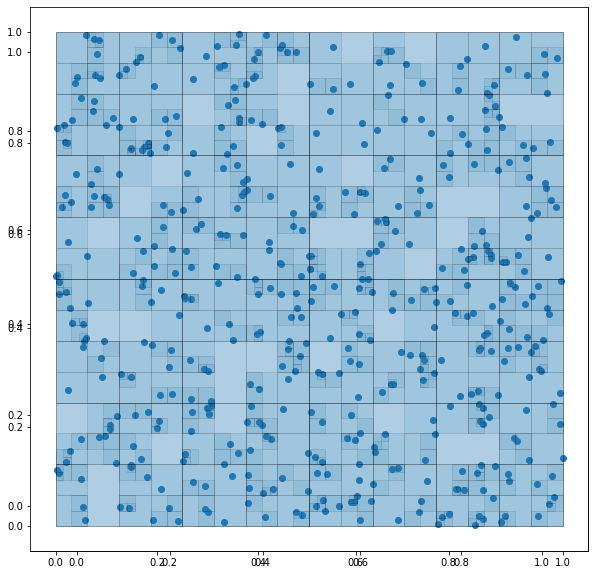

In [43]:
points = np.random.rand(500, 2)

X = points[:, 0]
Y = points[:, 1]

ax = plt.figure(figsize=(10, 10))
plt.xlim(-.1, 1.1)
plt.ylim(-.1, 1.1)

from collections import namedtuple
from collections import deque

def rolling(it, k=2):
    it = iter(it)
    q = deque(maxlen=2)
    
    for i in range(k):
        q.append(next(it))
    
    yield tuple(q)
    for v in it:
        q.append(v)
        yield(tuple(q))
        
print(list(rolling(range(5))))

class Quad(namedtuple("Quad", ("x1", "y1", "x2", "y2"))):

    @property
    def area(self):
        return self.width * self.height

    @property
    def width(self):
        return self.x2-self.x1

    @property
    def height(self):
        return self.y2-self.y1
    
    def __contains__(self, e):
        if type(e) == Quad:
            raise NotImplemented()
        
        elif len(e) == 2:
            x, y = e
            return (self.x1 <= x <= self.x2) and (self.y1 <= y <= self.y2)
    
    def to_patch(self):
        return np.array([(self.x1, self.y1), (self.x1, self.y2), (self.x2, self.y2), (self.x2, self.y1)])

    def split(self, k=4):
        lam = [i/k for i in range(k+1)]
        xs = [p*self.x2 + (1-p)*self.x1 for p in lam]
        ys = [p*self.y2 + (1-p)*self.y1 for p in lam]
        
        res = []
        for x1, x2 in rolling(xs):
            for y1, y2 in rolling(ys):
                res.append(Quad(x1, y1, x2, y2))
    
        
        return res
    
    def expand(self):
        # only works for k=3
        x1, x2 = [p*self.x2 + (1-p)*self.x1 for p in [-1, 2]]
        y1, y2 = [p*self.y2 + (1-p)*self.y1 for p in [-1, 2]]
        
        return Quad(x1, y1, x2, y2)
        

assert ((0.5, 1.5) in Quad(0, 0, 1, 1)) is False
assert ((0.5, 0.5) in Quad(0, 0, 1, 1)) is True

# print(Quad(0, 0, 1, 1).split())
print(Quad(0, 0, 1, 1).expand().area)

def build_tree(quad, points):
    if len(points) == 0:
        return []
    elif len(points) <= 1:
        return [quad]

    else:
        res = [quad]
        for q in quad.split(2):
            res.extend(build_tree(q, [p for p in points if p in q]))

        return res


bli = build_tree(Quad(0, 0, 1, 1), points)
ax = plt.axes()
for q in bli:
    ax.add_patch(plt.Polygon(q.to_patch(), alpha=0.1, ec="black"))

plt.scatter(X, Y)


In [44]:
factorissimo1_2

NameError: name 'factorissimo1_2' is not defined